In [1]:
import sys
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np
module_path = os.path.abspath(os.path.join('../..'))
if module_path + "/src/simulations_v2" not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
    
from load_params import load_params
from analysis_helpers import get_cumulative_infection_cols

from multi_group_simulation import MultiGroupSimulation
from vax_sim_utils import load_vax_group_configs, create_multigrp_vax_sim

In [2]:
UG_GA_vax_config = load_vax_group_configs(os.getcwd() + "/vax_sim_nominal_params/ug_greek_athlete_vax_config.yaml")
UG_other_vax_config = load_vax_group_configs(os.getcwd() + "/vax_sim_nominal_params/ug_other_vax_config.yaml")

/home/aaj54/group-testing/src/simulations_v2/vax_sim_utils.py:28: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  vax_config = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [3]:
contact_matrix = 10 * np.array([[92/125, 1/44],
                           [3.5/125, 6.5/44]]) # Calibrated contact matrix for UG groups

UG_group_params = UG_GA_vax_config[0] + UG_other_vax_config[0]
UG_vax_status = UG_GA_vax_config[1] + UG_other_vax_config[1]
GA_vax_perc = UG_GA_vax_config[0][0]['population_size'] / (UG_GA_vax_config[0][0]['population_size'] + UG_GA_vax_config[0][1]['population_size'])
other_vax_perc = UG_other_vax_config[0][0]['population_size'] / (UG_other_vax_config[0][0]['population_size'] + UG_other_vax_config[0][1]['population_size'])
UG_contact_matrix = np.zeros((4,4))

for row in range(4):
    if row < 2:
        UG_contact_matrix[row,:] = 10 * np.array([92/125 * GA_vax_perc, 92/125 * (1-GA_vax_perc), 1/44 * other_vax_perc, 1/44 * (1-other_vax_perc)])
    else:
        UG_contact_matrix[row,:] = 10 * np.array([3.5/125 * GA_vax_perc, 3.5/125 * (1-GA_vax_perc), 6.5/44 * other_vax_perc, 6.5/44 * (1-other_vax_perc)])

# Double contacts per day
UG_contact_matrix *= 2
for i in range(4):
    UG_group_params[i]['expected_contacts_per_day'] = UG_contact_matrix[i,i]

sim = create_multigrp_vax_sim(UG_group_params, UG_vax_status, UG_contact_matrix, 1, 0.3)

In [10]:
cum_inf_cols = get_cumulative_infection_cols(sim.run_new_trajectory(T=1)[1])
np.array(sim.run_new_trajectory(T=30)[1][cum_inf_cols].sum(axis=1))[-1]

6620.0

In [ ]:
# Graph. Scenario 1: 50% transmission mult for vax, Scenario 2: 100% tranmission mult for vax
# x-axis: Scaling contacts per day relative to Fall 2020 (1 -> 2)
# y-axis: Number of UG cases
# color: Masking vs non-masking

In [3]:
def get_sim(contact_mult, masking):
    contact_matrix = 10 * np.array([[92/125, 1/44],
                               [3.5/125, 6.5/44]]) # Calibrated contact matrix for UG groups

    UG_group_params = UG_GA_vax_config[0] + UG_other_vax_config[0]
    UG_vax_status = UG_GA_vax_config[1] + UG_other_vax_config[1]
    GA_vax_perc = UG_GA_vax_config[0][0]['population_size'] / (UG_GA_vax_config[0][0]['population_size'] + UG_GA_vax_config[0][1]['population_size'])
    other_vax_perc = UG_other_vax_config[0][0]['population_size'] / (UG_other_vax_config[0][0]['population_size'] + UG_other_vax_config[0][1]['population_size'])
    UG_contact_matrix = np.zeros((4,4))

    for row in range(4):
        if row < 2:
            UG_contact_matrix[row,:] = 10 * np.array([92/125 * GA_vax_perc, 92/125 * (1-GA_vax_perc), 1/44 * other_vax_perc, 1/44 * (1-other_vax_perc)])
        else:
            UG_contact_matrix[row,:] = 10 * np.array([3.5/125 * GA_vax_perc, 3.5/125 * (1-GA_vax_perc), 6.5/44 * other_vax_perc, 6.5/44 * (1-other_vax_perc)])

    # Double contacts per day
    UG_contact_matrix *= contact_mult
    if masking == True:
        UG_contact_matrix *= 0.8
    for i in range(4):
        UG_group_params[i]['expected_contacts_per_day'] = UG_contact_matrix[i,i]
        
    return UG_group_params, UG_vax_status, UG_contact_matrix

def get_case_counts(sim, N=50, T=30):
    inf_count = list()
    cum_inf_cols = get_cumulative_infection_cols(sim.run_new_trajectory(T=1)[1])
    for _ in range(N):
        inf_count.append(np.array(sim.run_new_trajectory(T)[1][cum_inf_cols].sum(axis=1))[-1])
    return np.quantile(inf_count, 0.1), np.quantile(inf_count, 0.5), np.quantile(inf_count, 0.9)
#     sim = create_multigrp_vax_sim(UG_group_params, UG_vax_status, UG_contact_matrix, 1, 0.3)

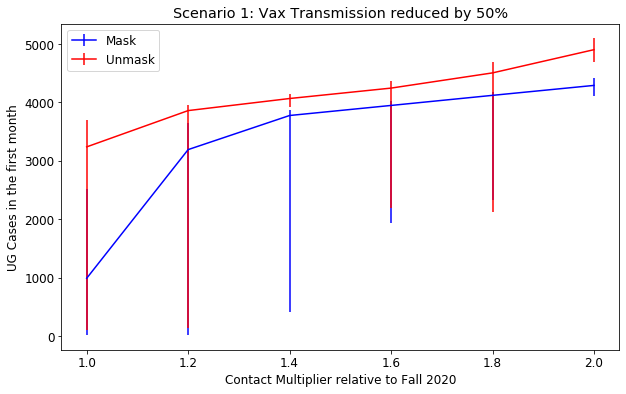

In [4]:
np.random.seed(2021)
# Scenario 1 graph
plt.figure(figsize=(10,6))
contacts_per_day_mults = [1, 1.2, 1.4, 1.6, 1.8, 2]

mask_med = list()
unmask_med = list()

mask_LB = list()
mask_UB = list()
unmask_LB = list()
unmask_UB = list()

label=True

for contact_mult in contacts_per_day_mults:
    UG_group_params, UG_vax_status, UG_contact_matrix = get_sim(contact_mult, True)
    sim = create_multigrp_vax_sim(UG_group_params, UG_vax_status, UG_contact_matrix, 0.5, 0.21)
    mask_inf_10, mask_inf_50, mask_inf_90 = get_case_counts(sim)
    mask_med.append(mask_inf_50)
    mask_LB.append(mask_inf_10)
    mask_UB.append(mask_inf_90)

    UG_group_params, UG_vax_status, UG_contact_matrix = get_sim(contact_mult, False)
    sim = create_multigrp_vax_sim(UG_group_params, UG_vax_status, UG_contact_matrix, 0.5, 0.21)
    unmask_inf_10, unmask_inf_50, unmask_inf_90 = get_case_counts(sim)
    unmask_med.append(unmask_inf_50)
    unmask_LB.append(unmask_inf_10)
    unmask_UB.append(unmask_inf_90)
#     if label:
#         print(mask_inf_10, mask_inf_50, mask_inf_90, [mask_inf_50 - mask_inf_10, mask_inf_90 - mask_inf_50])
#         plt.errorbar([contact_mult], [mask_inf_50], yerr=[mask_inf_50 - mask_inf_10, mask_inf_90 - mask_inf_50], color='blue', label='Mask')
#         plt.errorbar(contact_mult, unmask_inf_50, yerr=[unmask_inf_50-unmask_inf_10, unmask_inf_90-unmask_inf_50], color='red', label='Unmask')
#         label = False

mask_med = np.array(mask_med)
unmask_med = np.array(unmask_med)

mask_LB = np.array(mask_LB)
mask_UB = np.array(mask_UB)
unmask_LB = np.array(unmask_LB)
unmask_UB = np.array(unmask_UB)

plt.errorbar(contacts_per_day_mults, mask_med, yerr = [mask_med-mask_LB, mask_UB-mask_med], color='blue', label='Mask')
plt.errorbar(contacts_per_day_mults, unmask_med, yerr = [unmask_med-unmask_LB, unmask_UB-unmask_med], color='red', label='Unmask')

plt.title('Scenario 1: Vax Transmission reduced by 50%')
plt.xlabel('Contact Multiplier relative to Fall 2020')
plt.ylabel('UG Cases in the first month')
plt.legend()
plt.show()

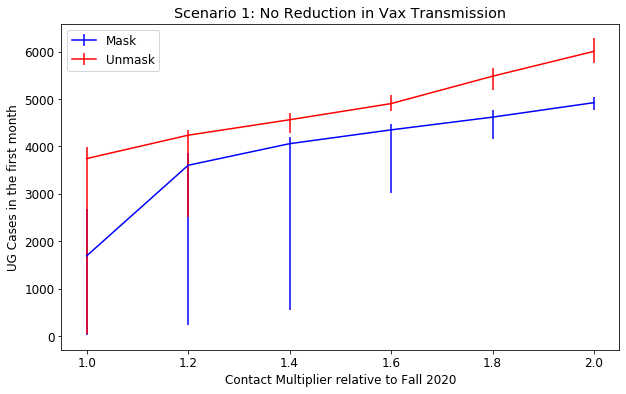

In [5]:
np.random.seed(2021)
# Scenario 1 graph
plt.figure(figsize=(10,6))
contacts_per_day_mults = [1, 1.2, 1.4, 1.6, 1.8, 2]

mask_med = list()
unmask_med = list()

mask_LB = list()
mask_UB = list()
unmask_LB = list()
unmask_UB = list()

label=True

for contact_mult in contacts_per_day_mults:
    UG_group_params, UG_vax_status, UG_contact_matrix = get_sim(contact_mult, True)
    sim = create_multigrp_vax_sim(UG_group_params, UG_vax_status, UG_contact_matrix, 1, 0.21)
    mask_inf_10, mask_inf_50, mask_inf_90 = get_case_counts(sim)
    mask_med.append(mask_inf_50)
    mask_LB.append(mask_inf_10)
    mask_UB.append(mask_inf_90)

    UG_group_params, UG_vax_status, UG_contact_matrix = get_sim(contact_mult, False)
    sim = create_multigrp_vax_sim(UG_group_params, UG_vax_status, UG_contact_matrix, 1, 0.21)
    unmask_inf_10, unmask_inf_50, unmask_inf_90 = get_case_counts(sim)
    unmask_med.append(unmask_inf_50)
    unmask_LB.append(unmask_inf_10)
    unmask_UB.append(unmask_inf_90)
#     if label:
#         print(mask_inf_10, mask_inf_50, mask_inf_90, [mask_inf_50 - mask_inf_10, mask_inf_90 - mask_inf_50])
#         plt.errorbar([contact_mult], [mask_inf_50], yerr=[mask_inf_50 - mask_inf_10, mask_inf_90 - mask_inf_50], color='blue', label='Mask')
#         plt.errorbar(contact_mult, unmask_inf_50, yerr=[unmask_inf_50-unmask_inf_10, unmask_inf_90-unmask_inf_50], color='red', label='Unmask')
#         label = False

mask_med = np.array(mask_med)
unmask_med = np.array(unmask_med)

mask_LB = np.array(mask_LB)
mask_UB = np.array(mask_UB)
unmask_LB = np.array(unmask_LB)
unmask_UB = np.array(unmask_UB)

plt.errorbar(contacts_per_day_mults, mask_med, yerr = [mask_med-mask_LB, mask_UB-mask_med], color='blue', label='Mask')
plt.errorbar(contacts_per_day_mults, unmask_med, yerr = [unmask_med-unmask_LB, unmask_UB-unmask_med], color='red', label='Unmask')

plt.title('Scenario 1: No Reduction in Vax Transmission')
plt.xlabel('Contact Multiplier relative to Fall 2020')
plt.ylabel('UG Cases in the first month')
plt.legend()
plt.show()

In [8]:
UG_GA_vax_config[0][0]['population_size'] + UG_GA_vax_config[0][1]['population_size'] + UG_other_vax_config[0][0]['population_size'] + UG_other_vax_config[0][1]['population_size']

11971

In [ ]:
UG_vax_config_matrix = 2 * UG_vax_config[2]
UG_vax_config[0][0]['expected_contacts_per_day'] *= 2
UG_vax_config[0][1]['expected_contacts_per_day'] *= 2

sim_pess = create_multigrp_vax_sim(UG_vax_config[0], UG_vax_config[1], UG_vax_config_matrix, 1, 0.3)
sim_opt = create_multigrp_vax_sim(UG_vax_config[0], UG_vax_config[1], UG_vax_config_matrix, 0.5, 0.3)

cum_inf_cols = get_cumulative_infection_cols(sim_pess.run_new_trajectory(T=1)[1])

# Plotting trajectories
n_trajs = 20
plt.figure(figsize=(10,6))
label = True
for _ in range(n_trajs):
    if label:
        plt.plot(sim_pess.run_new_trajectory(T=120)[1][cum_inf_cols].sum(axis=1), alpha=0.4, color='red', label='Pessimistic')
        plt.plot(sim_pess.run_new_trajectory(T=120)[1][cum_inf_cols].sum(axis=1), alpha=0.4, color='blue', label='Optimisitic')
        label = False
    else:
        plt.plot(sim_pess.run_new_trajectory(T=120)[1][cum_inf_cols].sum(axis=1), alpha=0.4, color='red')
        plt.plot(sim_pess.run_new_trajectory(T=120)[1][cum_inf_cols].sum(axis=1), alpha=0.4, color='blue')

plt.xlabel('Days in the Semester')
plt.ylabel('Cumulative Cases')
plt.title('UG Greek and Athlete Cases')
plt.legend()
plt.show()